In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")

dataframe = pd.read_csv(url, header=None)
dataframe.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
dataframe.columns = [
    'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
    'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'
]
dataframe = dataframe.drop(columns=['Sex'])

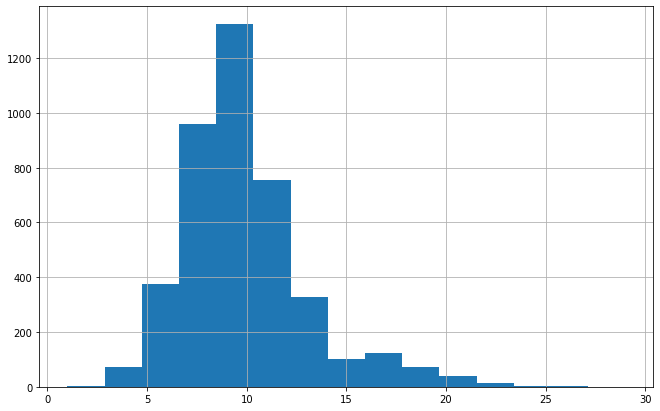

In [4]:
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
ax.hist(dataframe['Rings'], bins=15)
ax.grid(True)

In [5]:
corr_matrix = dataframe.corr()
corr_matrix

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


In [6]:
X = dataframe.drop(columns=['Rings'])
X = X.values
y = dataframe['Rings']
y = y.values

In [7]:
new_data_point = np.array([
    0.569552,
    0.446407,
    0.154437,
    1.016849,
    0.439051,
    0.222526,
    0.291208,
])

In [8]:
distances = np.linalg.norm(X - new_data_point, axis=1)

k = 3
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids

array([4045, 1902, 1644], dtype=int64)

In [9]:
nearest_neighbor_rings = y[nearest_neighbor_ids]
prediction = nearest_neighbor_rings.mean()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.3)

In [11]:
from sklearn.neighbors import KNeighborsRegressor

kNN_model = KNeighborsRegressor(n_neighbors=3)
kNN_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

prediction = kNN_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, prediction))
print(f"Root mean squared error: {rmse}")

Root mean squared error: 2.2899049581475928


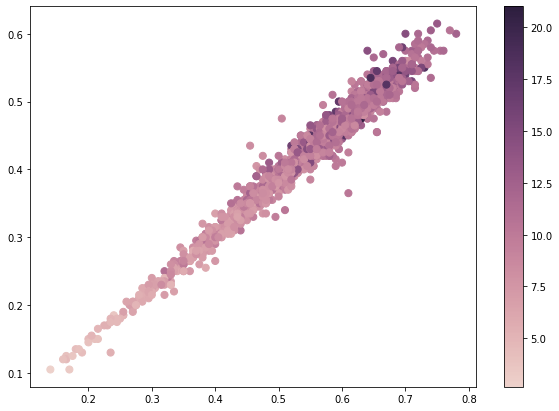

In [13]:
fig = plt.figure(figsize=(10, 7))
cmap = sns.cubehelix_palette(as_cmap=True)
ax = fig.add_subplot(111)
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=prediction, s=50, cmap=cmap)
fig.colorbar(points)

In [14]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(1, 50)}
grid_search = GridSearchCV(KNeighborsRegressor(), parameters)
grid_search.fit(X_train, y_train)

Wall time: 3.64 s


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [15]:
grid_search.best_params_

{'n_neighbors': 18}

In [16]:
grid_prediction = grid_search.predict(X_test)
grid_rmse = sqrt(mean_squared_error(y_test, grid_prediction))
print(f'RMSE with gridSearchCV - {grid_rmse}')

RMSE with gridSearchCV - 2.0005260251004926


In [17]:
parameters = {
    "n_neighbors": range(1, 30),
    "weights": ["uniform", "distance"],
}

grid_search_wweight = GridSearchCV(KNeighborsRegressor(), parameters)
grid_search_wweight.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']})

In [18]:
grid_search_wweight.best_params_

{'n_neighbors': 18, 'weights': 'distance'}

In [19]:
grid_prediction_ww = grid_search_wweight.predict(X_test)
grid_rmse_ww = sqrt(mean_squared_error(y_test, grid_prediction_ww))
print(f'RMSE with gridSearchCV with weight parameter - {grid_rmse_ww}')

RMSE with gridSearchCV with weight parameter - 1.998635802054234


In [20]:
from sklearn.ensemble import BaggingRegressor

best_k = grid_search_wweight.best_params_['n_neighbors']
best_w = grid_search_wweight.best_params_['weights']
bagged_kNN = KNeighborsRegressor(n_neighbors = best_k, weights = best_w)
bagging_model = BaggingRegressor(bagged_kNN, n_estimators=100)
bagging_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=18,
                                                    weights='distance'),
                 n_estimators=100)

In [21]:
bagged_prediction = bagging_model.predict(X_test)
bagged_rmse = sqrt(mean_squared_error(y_test, bagged_prediction))
print(f"RMSE with bagging technique: {bagged_rmse}")

RMSE with bagging technique: 1.9889954060746449
